<a href="https://colab.research.google.com/github/dauparas/tensorflow2_ipynb/blob/master/VAE_with_Gaussian_mixture_prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
from keras.layers import Input, Embedding, LSTM, Dense

import pandas as pd
from scipy.sparse import csr_matrix
import umap
from sklearn.metrics.cluster import adjusted_rand_score

import h5py
#Step 1: import dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from __future__ import division
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns; sns.set()
import keras.backend as K

import random

%matplotlib inline
plt.style.use('dark_background')

TensorFlow 2.x selected.


Using TensorFlow backend.


### Load Dataset

In [0]:
seed = 0
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [0]:
X, Y = make_blobs(n_samples=1000, n_features=200, centers=3, cluster_std=2.0)
X = X.astype(np.float32)
Y = Y

In [4]:
print(X.shape, Y.shape)

(1000, 200) (1000,)


In [5]:
umap_emb = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=seed).fit_transform(X);

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


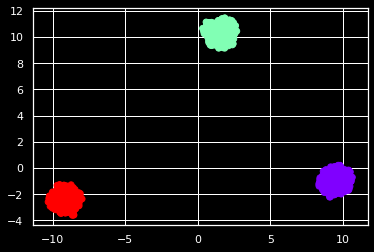

In [6]:
plt.scatter(umap_emb[:,0], umap_emb[:,1], c=Y, cmap='rainbow')

In [0]:
batch_size = 32
train_dataset = (X)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size)

# Create model

![alt text](https://drive.google.com/uc?id=12H05kEh2rsj-JiCkwPx782aF3ONyFxUp)

# Set prior

In [0]:
c_dim = 3
z_dim = 5
prior = tfd.Categorical(probs=tf.nn.softmax(tf.ones(c_dim)))

In [0]:
def make_c_given_x(input_shape, output_shape, act):
    model = tfk.Sequential([
    tfkl.InputLayer(input_shape=[input_shape]),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(output_shape, activation=None),
    ])
    return model

def make_z_given_c_x(input_shape, output_shape, act):
    model = tfk.Sequential([
    tfkl.InputLayer(input_shape=[input_shape]),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(2*output_shape, activation=None),
    ])
    return model  
  
def make_z_given_c(input_shape, output_shape, act):
    model = tfk.Sequential([
    tfkl.InputLayer(input_shape=[input_shape]),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(2*output_shape),
    ])
    return model  
  
def make_x_given_c_z(input_shape, output_shape, act):
    model = tfk.Sequential([
    tfkl.InputLayer(input_shape=[input_shape]),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(128, activation=act),
    tfkl.Dense(output_shape, activation=None),
    ])
    return model

In [0]:
c_given_x = make_c_given_x(X.shape[1], c_dim, tf.nn.leaky_relu)
z_given_c_x = make_z_given_c_x(c_dim+X.shape[1], z_dim, tf.nn.leaky_relu)
z_given_c = make_z_given_c(c_dim, z_dim, tf.nn.leaky_relu)
x_given_c_z = make_x_given_c_z(c_dim+z_dim, X.shape[1], tf.nn.leaky_relu)

In [0]:
optimizer = tf.keras.optimizers.Adam(3e-4)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(X):

    with tf.GradientTape() as tape:
      
      C1 = tf.one_hot(0*tf.ones(X.shape[0], tf.int32), c_dim, axis=-1)
      C2 = tf.one_hot(1*tf.ones(X.shape[0], tf.int32), c_dim, axis=-1)
      C3 = tf.one_hot(2*tf.ones(X.shape[0], tf.int32), c_dim, axis=-1)
      
      c_given_x_probs = tf.nn.softmax(c_given_x(X, training=True), axis=-1)
      c_given_x_distr = tfd.Categorical(probs=c_given_x_probs)
      
      z_given_c_mean_var1 = z_given_c(C1, training=True)
      z_given_c_mean1 = z_given_c_mean_var1[:,0:z_dim]
      z_given_c_log_var1 = z_given_c_mean_var1[:,z_dim:]
      z_given_c_distr1 = tfd.Independent(tfd.Normal(loc=z_given_c_mean1, scale=tf.nn.softplus(z_given_c_log_var1)),reinterpreted_batch_ndims=1)
      
      z_given_c_mean_var2 = z_given_c(C2, training=True)
      z_given_c_mean2 = z_given_c_mean_var2[:,0:z_dim]
      z_given_c_log_var2 = z_given_c_mean_var2[:,z_dim:]
      z_given_c_distr2 = tfd.Independent(tfd.Normal(loc=z_given_c_mean2, scale=tf.nn.softplus(z_given_c_log_var2)),reinterpreted_batch_ndims=1)
      
      z_given_c_mean_var3 = z_given_c(C3, training=True)
      z_given_c_mean3 = z_given_c_mean_var3[:,0:z_dim]
      z_given_c_log_var3 = z_given_c_mean_var3[:,z_dim:]
      z_given_c_distr3 = tfd.Independent(tfd.Normal(loc=z_given_c_mean3, scale=tf.nn.softplus(z_given_c_log_var3)),reinterpreted_batch_ndims=1)
      
      
      z_given_c_x_mean_var1 = z_given_c_x(tf.concat((C1, X), axis=-1), training=True)
      z_given_c_x_mean1 = z_given_c_x_mean_var1[:,0:z_dim]
      z_given_c_x_log_var1 = z_given_c_x_mean_var1[:,z_dim:]
      z_given_c_x_distr1 = tfd.Independent(tfd.Normal(loc=z_given_c_x_mean1, scale=tf.nn.softplus(z_given_c_x_log_var1)),reinterpreted_batch_ndims=1)
      
      z_given_c_x_mean_var2 = z_given_c_x(tf.concat((C2, X), axis=-1), training=True)
      z_given_c_x_mean2 = z_given_c_x_mean_var2[:,0:z_dim]
      z_given_c_x_log_var2 = z_given_c_x_mean_var2[:,z_dim:]
      z_given_c_x_distr2 = tfd.Independent(tfd.Normal(loc=z_given_c_x_mean2, scale=tf.nn.softplus(z_given_c_x_log_var2)),reinterpreted_batch_ndims=1)
      
      z_given_c_x_mean_var3 = z_given_c_x(tf.concat((C3, X), axis=-1), training=True)
      z_given_c_x_mean3 = z_given_c_x_mean_var3[:,0:z_dim]
      z_given_c_x_log_var3 = z_given_c_x_mean_var3[:,z_dim:]
      z_given_c_x_distr3 = tfd.Independent(tfd.Normal(loc=z_given_c_x_mean3, scale=tf.nn.softplus(z_given_c_x_log_var3)),reinterpreted_batch_ndims=1)
      
      kl_z_c1 = tfd.kl_divergence(z_given_c_x_distr1, z_given_c_distr1)
      kl_z_c2 = tfd.kl_divergence(z_given_c_x_distr2, z_given_c_distr2)
      kl_z_c3 = tfd.kl_divergence(z_given_c_x_distr3, z_given_c_distr3)
      x1 = x_given_c_z(tf.concat((C1, z_given_c_x_distr1.sample()), axis=-1), training=True)  
      x2 = x_given_c_z(tf.concat((C2, z_given_c_x_distr2.sample()), axis=-1), training=True) 
      x3 = x_given_c_z(tf.concat((C3, z_given_c_x_distr3.sample()), axis=-1), training=True)
      rec1 = tf.reduce_mean(tf.square(X-x1), axis=-1)
      rec2 = tf.reduce_mean(tf.square(X-x2), axis=-1)
      rec3 = tf.reduce_mean(tf.square(X-x3), axis=-1)
                       
      kl_c = tf.reduce_mean(tfd.kl_divergence(c_given_x_distr, prior))
      beta = 1.0
      gamma = 1.0
      loss = tf.reduce_mean(c_given_x_probs[:,0]*(rec1+beta*kl_z_c1)+c_given_x_probs[:,1]*(rec2+beta*kl_z_c2)+c_given_x_probs[:,2]*(rec3+beta*kl_z_c3))+gamma*kl_c
     

    gradients = tape.gradient(loss, c_given_x.trainable_variables + z_given_c_x.trainable_variables+z_given_c.trainable_variables+x_given_c_z.trainable_variables)

    optimizer.apply_gradients(zip(gradients, c_given_x.trainable_variables + z_given_c_x.trainable_variables+z_given_c.trainable_variables+x_given_c_z.trainable_variables))
    return loss

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for X_batch in dataset:
      loss = train_step(X_batch)
    if ((epoch+1) % 20 == 0 or epoch==0):
      print('Epoch: {0:.1f}, loss: {1:.5f}'.format(epoch+1, loss.numpy()))
  return None

In [15]:
%%time
train(train_dataset, 100)

Epoch: 1.0, loss: 38.26413
Epoch: 20.0, loss: 5.03968
Epoch: 40.0, loss: 5.29566
Epoch: 60.0, loss: 5.18125
Epoch: 80.0, loss: 5.07261
Epoch: 100.0, loss: 5.25471
CPU times: user 34.9 s, sys: 4.36 s, total: 39.2 s
Wall time: 30.4 s


In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def test_step(X):
      
      C1 = tf.one_hot(0*tf.ones(X.shape[0], tf.int32), c_dim, axis=-1)
      C2 = tf.one_hot(1*tf.ones(X.shape[0], tf.int32), c_dim, axis=-1)
      C3 = tf.one_hot(2*tf.ones(X.shape[0], tf.int32), c_dim, axis=-1)
      
      c_given_x_probs = tf.nn.softmax(c_given_x(X, training=True), axis=-1)
      c_given_x_distr = tfd.Categorical(probs=c_given_x_probs)
      
      z_given_c_mean_var1 = z_given_c(C1, training=True)
      z_given_c_mean1 = z_given_c_mean_var1[:,0:z_dim]
      z_given_c_log_var1 = z_given_c_mean_var1[:,z_dim:]
      z_given_c_distr1 = tfd.Independent(tfd.Normal(loc=z_given_c_mean1, scale=tf.nn.softplus(z_given_c_log_var1)),reinterpreted_batch_ndims=1)
      
      z_given_c_mean_var2 = z_given_c(C2, training=True)
      z_given_c_mean2 = z_given_c_mean_var2[:,0:z_dim]
      z_given_c_log_var2 = z_given_c_mean_var2[:,z_dim:]
      z_given_c_distr2 = tfd.Independent(tfd.Normal(loc=z_given_c_mean2, scale=tf.nn.softplus(z_given_c_log_var2)),reinterpreted_batch_ndims=1)
      
      z_given_c_mean_var3 = z_given_c(C3, training=True)
      z_given_c_mean3 = z_given_c_mean_var3[:,0:z_dim]
      z_given_c_log_var3 = z_given_c_mean_var3[:,z_dim:]
      z_given_c_distr3 = tfd.Independent(tfd.Normal(loc=z_given_c_mean3, scale=tf.nn.softplus(z_given_c_log_var3)),reinterpreted_batch_ndims=1)
      
      
      z_given_c_x_mean_var1 = z_given_c_x(tf.concat((C1, X), axis=-1), training=True)
      z_given_c_x_mean1 = z_given_c_x_mean_var1[:,0:z_dim]
      z_given_c_x_log_var1 = z_given_c_x_mean_var1[:,z_dim:]
      z_given_c_x_distr1 = tfd.Independent(tfd.Normal(loc=z_given_c_x_mean1, scale=tf.nn.softplus(z_given_c_x_log_var1)),reinterpreted_batch_ndims=1)
      
      z_given_c_x_mean_var2 = z_given_c_x(tf.concat((C2, X), axis=-1), training=True)
      z_given_c_x_mean2 = z_given_c_x_mean_var2[:,0:z_dim]
      z_given_c_x_log_var2 = z_given_c_x_mean_var2[:,z_dim:]
      z_given_c_x_distr2 = tfd.Independent(tfd.Normal(loc=z_given_c_x_mean2, scale=tf.nn.softplus(z_given_c_x_log_var2)),reinterpreted_batch_ndims=1)
      
      z_given_c_x_mean_var3 = z_given_c_x(tf.concat((C3, X), axis=-1), training=True)
      z_given_c_x_mean3 = z_given_c_x_mean_var3[:,0:z_dim]
      z_given_c_x_log_var3 = z_given_c_x_mean_var3[:,z_dim:]
      z_given_c_x_distr3 = tfd.Independent(tfd.Normal(loc=z_given_c_x_mean3, scale=tf.nn.softplus(z_given_c_x_log_var3)),reinterpreted_batch_ndims=1)
      
      kl_z_c1 = tfd.kl_divergence(z_given_c_x_distr1, z_given_c_distr1)
      kl_z_c2 = tfd.kl_divergence(z_given_c_x_distr2, z_given_c_distr2)
      kl_z_c3 = tfd.kl_divergence(z_given_c_x_distr3, z_given_c_distr3)
      x1 = x_given_c_z(tf.concat((C1, z_given_c_x_distr1.sample()), axis=-1), training=True)  
      x2 = x_given_c_z(tf.concat((C2, z_given_c_x_distr2.sample()), axis=-1), training=True) 
      x3 = x_given_c_z(tf.concat((C3, z_given_c_x_distr3.sample()), axis=-1), training=True)
      rec1 = tf.reduce_mean(tf.square(X-x1), axis=-1)
      rec2 = tf.reduce_mean(tf.square(X-x2), axis=-1)
      rec3 = tf.reduce_mean(tf.square(X-x3), axis=-1)
                       
      kl_c = tf.reduce_mean(tfd.kl_divergence(c_given_x_distr, prior))
      beta = 1.0
      gamma = 1.0
      loss = tf.reduce_mean(c_given_x_probs[:,0]*(rec1+beta*kl_z_c1)+c_given_x_probs[:,1]*(rec2+beta*kl_z_c2)+c_given_x_probs[:,2]*(rec3+beta*kl_z_c3))+gamma*kl_c
      
      C = tf.one_hot(c_given_x_distr.sample(), c_dim, axis=-1)
      z_given_c_x_mean_var = z_given_c_x(tf.concat((C, X), axis=-1), training=True)
      z_given_c_x_mean = z_given_c_x_mean_var[:,0:z_dim]
      z_given_c_x_log_var = z_given_c_x_mean_var[:,z_dim:]
      z_given_c_x_distr = tfd.Independent(tfd.Normal(loc=z_given_c_x_mean, scale=tf.nn.softplus(z_given_c_x_log_var)),reinterpreted_batch_ndims=1)
      
      return loss, c_given_x_probs, z_given_c_x_distr.mean()

In [0]:
loss, c_given_x_probs, z_mean = test_step(X)

In [18]:
c_given_x_probs

<tf.Tensor: id=12561, shape=(1000, 3), dtype=float32, numpy=
array([[1.0000000e+00, 2.9054508e-09, 2.2069688e-08],
       [4.8766777e-09, 7.3870776e-09, 1.0000000e+00],
       [3.2487848e-09, 1.0942055e-08, 1.0000000e+00],
       ...,
       [8.6670576e-10, 1.0000000e+00, 2.7406291e-09],
       [2.0746744e-09, 1.0000000e+00, 6.5477095e-09],
       [1.0000000e+00, 5.6065375e-09, 1.8042773e-08]], dtype=float32)>

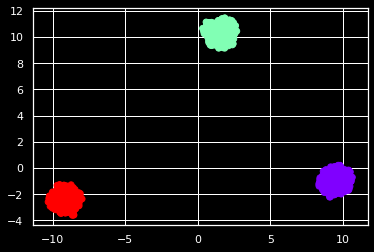

In [19]:
plt.scatter(umap_emb[:,0], umap_emb[:,1], c=Y, cmap='rainbow')

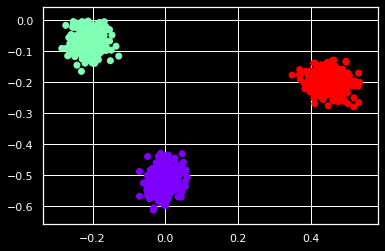

In [20]:
plt.scatter(z_mean[:,0], z_mean[:,1], c=np.argmax(c_given_x_probs.numpy(), axis=-1), cmap='rainbow')

1. Calculating expectation with respect to q(c|x) required c_dim runs of the neural network. 
2. How does one set the level of KL divergence loss for c?